In [3]:
import cirq
import numpy as np
import tensorflow_quantum as tfq
import pandas as pd

from qite import QITE
from circuit import build_ansatz, initialize_ansatz_symbols
from problem import build_ising_model_hamiltonian
from utils import evaluate_exact_state, plot_density_matrix_heatmap, get_ancillary_qubits, save_circuit_to_svg

## Define global variables

Define global variables such as temperature used for determining evolution time

In [4]:
kBT = 1
evolution_time = 1 / (2 * kBT)
n_hamiltonian_qubits = 4
n_timesteps = 100

## Generate Hamiltonian

We generate a transverse field Ising model Hamiltonian of 4 "fully connected" qubits with coefficients sampled from uniform distribution of -2 to 2.

In [25]:
hamiltonian, problem_qubits = build_ising_model_hamiltonian([n_hamiltonian_qubits], random=True, random_low = -2, random_high=2)

In [26]:
print(hamiltonian)

-0.680*Z((0, 0))*Z((1, 0))+1.521*Z((0, 0))*Z((2, 0))-0.917*Z((0, 0))*Z((3, 0))-1.057*Z((1, 0))*Z((2, 0))-0.674*Z((1, 0))*Z((3, 0))+1.532*Z((2, 0))*Z((3, 0))+1.122*Z((0, 0))+1.449*X((0, 0))-1.404*Z((1, 0))-0.645*X((1, 0))-0.719*Z((2, 0))-1.674*X((2, 0))-1.043*Z((3, 0))+1.714*X((3, 0))


## Exact thermal state

Exact thermal state solved analytically from matrix exponential.

In [27]:
exact_state = evaluate_exact_state(hamiltonian, evolution_time)

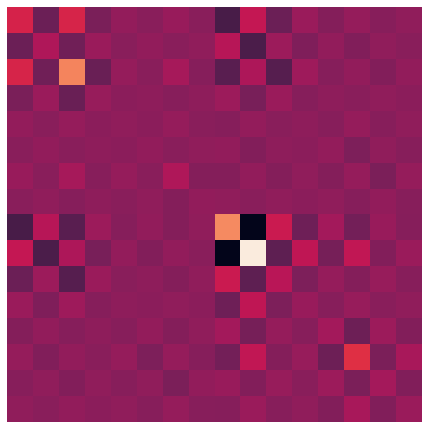

In [28]:
plot_density_matrix_heatmap([exact_state], show = True, size = 6)

## Define a variational circuit for VarQITE

Define a variational quantum circuit for VarQITE with good representation capabilities.

In [29]:
n_layers = 3
rotations = [cirq.ry, cirq.rz]
entanglers = [cirq.CNOT]
pattern = "chain"
ancillary_qubits = get_ancillary_qubits(problem_qubits)
qubits = [*problem_qubits, *ancillary_qubits]

circuit, symbol_names = build_ansatz(
    qubits, n_layers, rotations, entanglers, pattern
)
initial_symbol_values = initialize_ansatz_symbols(
    len(qubits),
    n_layers,
    len(rotations),
    0,
    np.pi / 2,
    len(entanglers),
    pattern,
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


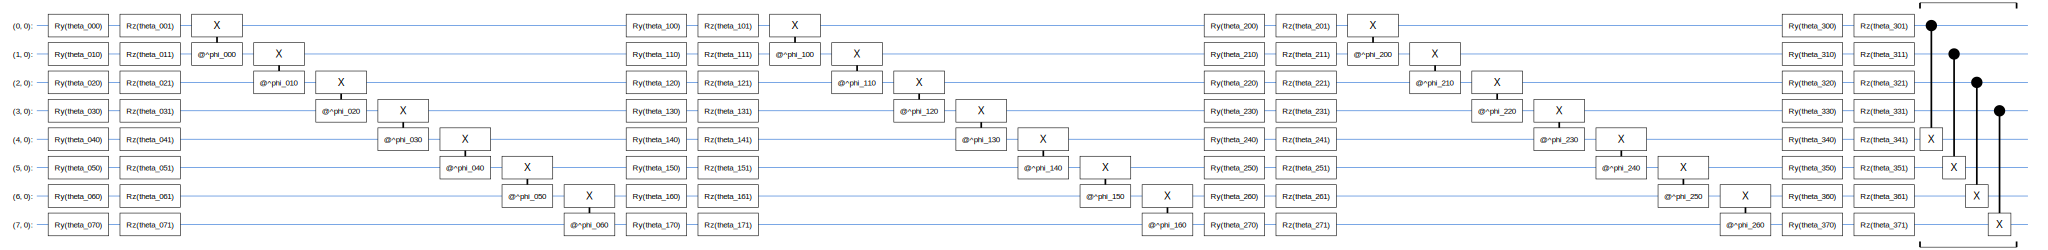

In [30]:
save_circuit_to_svg(circuit, show = True)

## Run variational quantum imaginary time evolution (VarQITE)

In [31]:
qite = QITE(verbose = 3)
final_symbol_values, final_state, metrics = qite.run(
    circuit,
    hamiltonian,
    symbol_names,
    initial_symbol_values,
    evolution_time,
    exact_state,
    n_timesteps=n_timesteps
)

QITE:   0%|          | 0/100 [00:00<?, ?it/s]

QITE timestep   0: [energy = 0.000, fidelity = 0.450, quantum_relative_entropy = 1.236, trace_distance = 0.637]
QITE timestep   1: [energy = 0.000, fidelity = 0.459, quantum_relative_entropy = 1.206, trace_distance = 0.630]
QITE timestep   2: [energy = -0.098, fidelity = 0.468, quantum_relative_entropy = 1.176, trace_distance = 0.623]
QITE timestep   3: [energy = -0.196, fidelity = 0.478, quantum_relative_entropy = 1.147, trace_distance = 0.616]
QITE timestep   4: [energy = -0.294, fidelity = 0.487, quantum_relative_entropy = 1.119, trace_distance = 0.609]
QITE timestep   5: [energy = -0.391, fidelity = 0.496, quantum_relative_entropy = 1.090, trace_distance = 0.603]
QITE timestep   6: [energy = -0.489, fidelity = 0.506, quantum_relative_entropy = 1.063, trace_distance = 0.597]
QITE timestep   7: [energy = -0.586, fidelity = 0.515, quantum_relative_entropy = 1.036, trace_distance = 0.591]
QITE timestep   8: [energy = -0.683, fidelity = 0.525, quantum_relative_entropy = 1.009, trace_dis

## Plot comparison

Plot the density matrices of the VarQITE prepared thermal state and the analytic solution

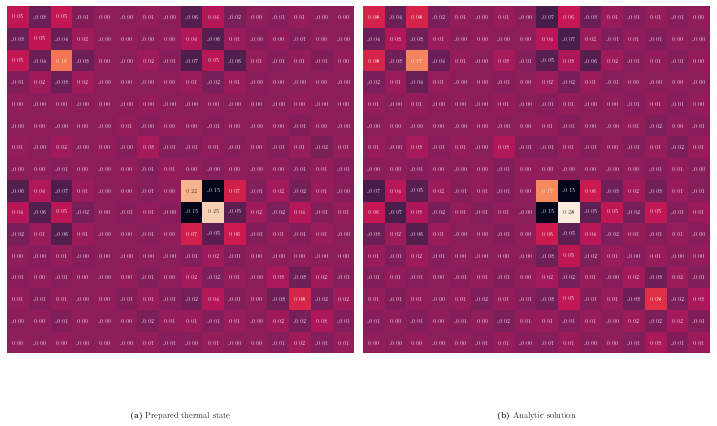

In [32]:
plot_density_matrix_heatmap([final_state, exact_state], titles = ["Prepared thermal state", "Analytic solution"], annot = True, size = 10)

## Print metrics from VarQITE

In [34]:
df = pd.DataFrame.from_dict(metrics)
print(df.head(10))
print(df.tail(10))

   time_step    energy  fidelity  quantum_relative_entropy  trace_distance
0          0  0.000001  0.449730                  1.235851        0.636920
1          1  0.000001  0.459004                  1.205852        0.629933
2          2 -0.097968  0.468317                  1.176315        0.622859
3          3 -0.195877  0.477665                  1.147241        0.615706
4          4 -0.293671  0.487040                  1.118634        0.609460
5          5 -0.391300  0.496434                  1.090494        0.603479
6          6 -0.488710  0.505844                  1.062821        0.597419
7          7 -0.585852  0.515260                  1.035619        0.591283
8          8 -0.682673  0.524676                  1.008887        0.585074
9          9 -0.779127  0.534085                  0.982626        0.578797
     time_step    energy  fidelity  quantum_relative_entropy  trace_distance
91          91 -5.692026  0.964977                  0.091765        0.157806
92          92 -5.720